In [1]:
import pickle

In [2]:
import numpy
import scipy
import pandas
import spacy
import textacy

In [3]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [24]:
with open('/home/immersinn/Dropbox/Analytics/NCGA/data/bill_page_keywords.pkl', 'rb') as f1:
    keywords = pickle.load(f1)

In [25]:
keywords.head()

,bill,house,session,keywords
0,1,H,2015E4,"[ADOPTED, GENERAL ASSEMBLY, RESOLUTIONS, SIMPL..."
1,2,H,2015E4,"[ADJOURNMENT, GENERAL ASSEMBLY, RESOLUTIONS, J..."
2,3,H,2015E4,"[ADMINISTRATION DEPT., ADMINISTRATIVE CODE, AD..."
3,4,H,2015E4,"[BRIDGES, CONTRACTS, COUNTIES, INFRASTRUCTURE,..."
4,5,H,2015E4,"[COUNTIES, EDGECOMBE COUNTY, INFORMATION TECHN..."


## Keywords Stuff

In [26]:
from collections import defaultdict

In [27]:
keycounts = defaultdict(int)

In [28]:
def updateKeycounts(kws):
    for kw in kws:
        keycounts[kw] += 1

In [29]:
_ = keywords.apply(lambda x: updateKeycounts(x.keywords), axis=1)

In [30]:
keycounts = pandas.DataFrame({"word" : [w for w in keycounts.keys()],
                              "count" : [c for c in keycounts.values()]})

In [31]:
keycounts.sort_values(by="count", ascending=False, inplace=True)
keycounts.index = range(keycounts.shape[0])

In [32]:
keycounts.head()

,count,word
0,1702,PUBLIC
1,530,EDUCATION
2,506,LOCAL GOVERNMENT
3,468,RATIFIED
4,465,CHAPTERED


In [33]:
keycounts['count'].describe(percentiles=[.25, .50, .75, .80, .85, .90, .95])

count    1341.000000
mean       22.394482
std        69.208145
min         1.000000
25%         2.000000
50%         5.000000
75%        15.000000
80%        20.000000
85%        31.000000
90%        47.000000
95%        99.000000
max      1702.000000
Name: count, dtype: float64

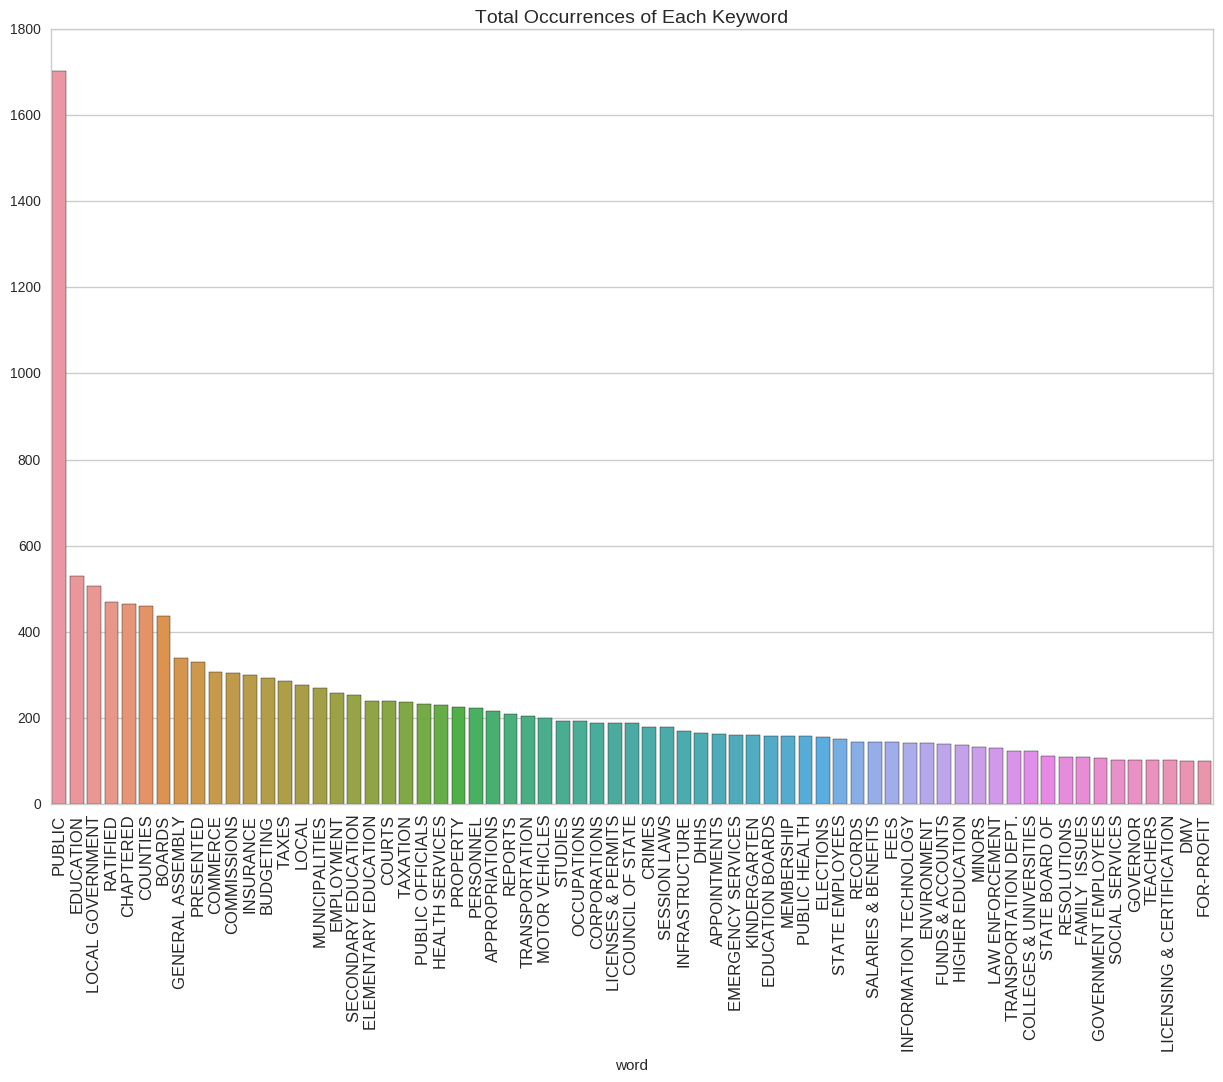

In [34]:
g = sns.barplot(x="word", y="count", data=keycounts[keycounts['count']>=100], estimator=sum);
g.figure.set_size_inches(15,10);
plt.xticks(rotation="vertical", size=12);
plt.title('Total Occurrences of Each Keyword', size=14);
plt.ylabel("");

+ Documetns with similar sets of keywords should have similar content
+ a document can be represented by a vector indicating whether a keyword is present or absent for the codument
+ Distances between these vectors can be used to cluster / group documents

In [35]:
from sklearn import metrics, feature_extraction, feature_selection, cluster

#### Convert Keyword Lists to Vectorspace, Calc Similarities

In [36]:
def list2dict(l):
    return({n : 1 for n in l})

In [37]:
keywords['kyd'] = keywords.apply(lambda x: list2dict(x.keywords), axis=1)

In [38]:
keywords.kyd[0]

{'ADOPTED': 1,
 'GENERAL ASSEMBLY': 1,
 'HOUSE & SENATE': 1,
 'RESOLUTIONS': 1,
 'RULES': 1,
 'SIMPLE': 1}

In [39]:
kwDV = feature_extraction.DictVectorizer()

In [40]:
kw_feats = kwDV.fit_transform(keywords['kyd']).todense()

In [41]:
kw_feats.shape

(2100, 1341)

In [42]:
len(kwDV.get_feature_names())

1341

In [43]:
# Restrict the features being used
# keywords must occur at least 10 times in the data;
# larger requirements result in too many groups due to 
count_cutoff = 1
support = keycounts.apply(lambda x: x['count'] >= count_cutoff, axis=1)

In [44]:
kwDV.restrict(support)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True)

In [45]:
len(kwDV.get_feature_names())

1341

In [46]:
kw_feats = kwDV.transform(keywords['kyd']).todense()

In [47]:
kw_feats.shape

(2100, 1341)

In [48]:
pandas.Series(numpy.array(kw_feats.sum(axis=1)).reshape([2100,])).describe()

count    2100.000000
mean       14.090952
std        18.888374
min         1.000000
25%         8.000000
50%        11.000000
75%        15.000000
max       428.000000
dtype: float64

In [49]:
kw_cos = metrics.pairwise.cosine_similarity(kw_feats)

#### Perform clustering

In [50]:
bandwidth = cluster.estimate_bandwidth(kw_feats, quantile=0.3, n_samples=1000, n_jobs=4)

In [51]:
ms = cluster.MeanShift(bandwidth=bandwidth, n_jobs=4)
ms.fit(kw_feats)

MeanShift(bandwidth=4.3394069887932467, bin_seeding=False, cluster_all=True,
     min_bin_freq=1, n_jobs=4, seeds=None)

In [52]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = numpy.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 99


In [53]:
cc_vals = pandas.Series(cluster_centers.reshape([cluster_centers.size,]))

In [54]:
cc_vals.describe(percentiles=[0.50, 0.80, 0.90, 0.95, 0.975, 0.99])

count    132759.000000
mean          0.046333
std           0.209671
min           0.000000
50%           0.000000
80%           0.000000
90%           0.000000
95%           0.003158
97.5%         1.000000
99%           1.000000
max           1.000000
dtype: float64